In [13]:
import torch.optim as optim
from deepsplines.ds_modules import dsnn
import torch.nn as nn
import torch
import numpy as np
import wandb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_default_dtype(torch.float)
device = torch.device('cpu' if torch.backends.mps.is_available() else 'mps')

In [3]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()
print(data.feature_names)
 
X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [8]:
class LeakyreluModel(nn.Module):
    def __init__(self,epochs,lr):

        super(LeakyreluModel,self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(8, 24),
                        nn.LeakyReLU(),
                        nn.Linear(24, 12),
                        nn.LeakyReLU(),
                        nn.Linear(12, 8),
                        nn.LeakyReLU(),
                        nn.Linear(8, 1)
                    )
        self.epochs = epochs
        self.lr = lr
    
    def forward(self,x):
        return self.model(x)
    
    def fit(self,X,y):
        self.train()
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()}, step=epoch)
            if epoch % 100 == 0:
                print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        return loss.item()
    
    def predict(self,X,y):
        self.eval()
        criterion = nn.MSELoss()
        with torch.no_grad():
            y_pred = self.forward(X)
        loss= criterion(y_pred, y)
        #print('test loss: {}'.format(loss.item()))
        return loss.item()



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [11]:
model=LeakyreluModel(epochs=2000,lr=1e-3)

loss_tr=model.fit(X_train,y_train)

Epoch 0: train loss: 163.7046661376953
Epoch 100: train loss: 2.7282865047454834
Epoch 200: train loss: 1.3204810619354248
Epoch 300: train loss: 1.2685766220092773
Epoch 400: train loss: 1.2452003955841064
Epoch 500: train loss: 1.218224048614502
Epoch 600: train loss: 1.1710888147354126
Epoch 700: train loss: 1.083484172821045
Epoch 800: train loss: 0.8217023611068726
Epoch 900: train loss: 0.6493534445762634
Epoch 1000: train loss: 0.6156958341598511
Epoch 1100: train loss: 0.607184112071991
Epoch 1200: train loss: 0.57501220703125
Epoch 1300: train loss: 0.5543628931045532
Epoch 1400: train loss: 0.5389127135276794
Epoch 1500: train loss: 0.5258008241653442
Epoch 1600: train loss: 0.5192627310752869
Epoch 1700: train loss: 0.5002139210700989
Epoch 1800: train loss: 0.494269460439682
Epoch 1900: train loss: 0.4911653697490692


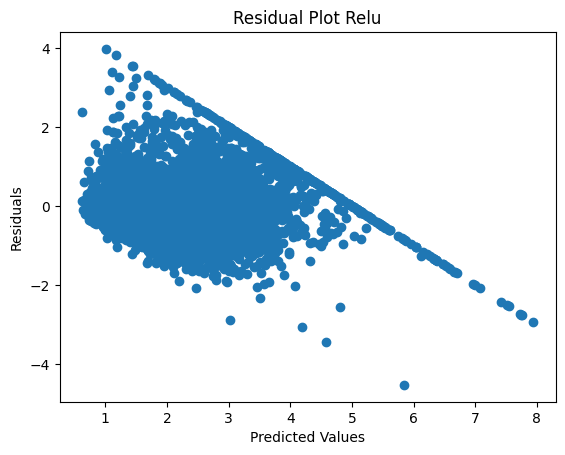

In [20]:
y_pred=model.forward(X_test).detach().numpy()
residuals = (y_test - y_pred).detach().numpy()
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot Relu')
plt.show()